# Previsione dei Costi Assicurativi Sanitari

In questo notebook vengono esplorati tre approcci per la previsione dei costi assicurativi sanitari, basati su reti neurali:

1. **Multi Layer Perceptron (MLP) Standard**
2. **Kolmogorov-Arnold Network (KAN)**

Il dataset utilizzato è il **Medical Insurance Cost Dataset**, che contiene informazioni demografiche e di stile di vita, ed è disponibile pubblicamente. Verranno illustrate le fasi di importazione, preprocessing, definizione dei modelli, allenamento e valutazione.

## Panoramica

- **Dataset:** Contiene variabili numeriche e categoriche relative a pazienti (età, IMC, numero di figli, etc.) e informazioni su sesso, fumo e regione.
- **Preprocessing:** Codifica one-hot per le variabili categoriche e normalizzazione delle feature numeriche.
- **Modelli:**
  - *MLP Standard*: Rete neurale classica con due hidden layer.
  - *KAN*: Un layer personalizzato che applica una trasformazione spline (approssimazione ispirata alle idee di Kolmogorov-Arnold).

Procediamo con il codice!

In [ ]:
!pip install pykan

In [ ]:
# Importazione delle librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from kan import *
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display

cuda


## 1. Caricamento e Preprocessing del Dataset

In questa sezione viene caricato il dataset dal repository online.
- **Codifica delle variabili categoriche:** Vengono utilizzate le _dummy variables_ (one-hot encoding) per variabili come `sex`, `smoker` e `region`.
- **Normalizzazione:** Le feature numeriche vengono scalate con lo StandardScaler.
- **Divisione in Training, Validation e Test set:** Viene effettuata una suddivisione in modo da poter valutare il modello su dati non visti.

In [ ]:
# Caricamento del dataset
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
data = pd.read_csv(url)

# Visualizzazione delle prime righe
print(data.head())

# Codifica delle variabili categoriche (one-hot encoding) e rimozione della prima colonna per evitare la multicollinearità
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)

# Separazione delle feature e del target
X = data.drop(columns=['charges'])
y = data['charges']

# Normalizzazione delle feature numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversione in tensori PyTorch (correggendo le dimensioni)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Convertito in (n,1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)  # Anche qui (n,1)

# Creazione del DataLoader per il training e la validazione
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Training set: (936, 8), Validation set: (201, 8), Test set: (201, 8)


## 2. Modello MLP Standard

Il modello MLP standard è una rete neurale feedforward composta da due hidden layer (64 e 32 neuroni) con funzione di attivazione ReLU e un output layer per regressione (nessuna attivazione).

Viene compilato con l'ottimizzatore Adam e la funzione di loss _mean squared error_ (MSE).

In [ ]:
mse_history = {'MLP': {'val': [], 'test': []}, 'KAN': {'val': [], 'test': []}}

# Definizione del modello MLP in PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inizializzazione del modello
input_dim = X_train.shape[1]
mlp_model = MLP(input_dim).to(device)

# Definizione della loss e dell'ottimizzatore
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Early stopping manuale
best_val_loss = float("inf")
patience = 10
counter = 0

# Training del modello
num_epochs = 5000
for epoch in range(num_epochs):
    mlp_model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = mlp_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validazione
    mlp_model.eval()
    with torch.no_grad():
        y_val_pred = mlp_model(X_val_tensor.to(device))
        val_loss = criterion(y_val_pred, y_val_tensor.to(device)).item()

    mse_history['MLP']['test'].append(epoch_loss)
    mse_history['MLP']['val'].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = mlp_model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# Ripristino dei migliori pesi
mlp_model.load_state_dict(best_model_state)

Epoch 1/5000, Loss: 9596634080.0000, Val Loss: 297396832.0000
Epoch 2/5000, Loss: 9783301600.0000, Val Loss: 297377280.0000
Epoch 3/5000, Loss: 10004328752.0000, Val Loss: 297351808.0000
Epoch 4/5000, Loss: 9586187760.0000, Val Loss: 297317888.0000
Epoch 5/5000, Loss: 9625936656.0000, Val Loss: 297274720.0000
Epoch 6/5000, Loss: 9719762000.0000, Val Loss: 297220096.0000
Epoch 7/5000, Loss: 9698385368.0000, Val Loss: 297153824.0000
Epoch 8/5000, Loss: 9669770912.0000, Val Loss: 297070816.0000
Epoch 9/5000, Loss: 9738733888.0000, Val Loss: 296973536.0000
Epoch 10/5000, Loss: 10187337376.0000, Val Loss: 296859744.0000
Epoch 11/5000, Loss: 9606974896.0000, Val Loss: 296721664.0000
Epoch 12/5000, Loss: 9569073984.0000, Val Loss: 296577056.0000
Epoch 13/5000, Loss: 9550399472.0000, Val Loss: 296413504.0000
Epoch 14/5000, Loss: 9751585488.0000, Val Loss: 296238336.0000
Epoch 15/5000, Loss: 9551030128.0000, Val Loss: 296037984.0000
Epoch 16/5000, Loss: 10353407728.0000, Val Loss: 295825856.000

<All keys matched successfully>

## 3. Modello Kolmogorov-Arnold Network (KAN)

Il KAN è un approccio che in questo esempio viene implementato con un layer personalizzato che applica una trasformazione spline.

**Nota:** L'implementazione qui presentata è una versione semplificata per illustrare l'idea di usare spline come parte della trasformazione dei dati.

Nel layer `KANLayer`:

- Vengono definiti dei nodi (knots) per la spline.
- Vengono generati dei coefficienti casuali per definire la spline tramite la funzione `BSpline` di SciPy.
- La funzione `call` applica la spline agli input.

In [ ]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Inizializzazione del modello KAN
input_dim = X_train.shape[1]
kan_model = KAN(
    width=[input_dim, 4, 1],
    grid=4,
    k=3,
    seed=0,
    device=device
)

# Funzioni per il calcolo della loss su un batch
def train_mse():
    with torch.no_grad():
        X_train_batch, y_train_batch = next(iter(train_loader))
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)
        predictions = kan_model(X_train_batch)
        mse = torch.nn.functional.mse_loss(predictions, y_train_batch)
    return mse

def test_mse():
    with torch.no_grad():
        X_val_batch, y_val_batch = next(iter(val_loader))
        X_val_batch = X_val_batch.to(device)
        y_val_batch = y_val_batch.to(device)
        predictions = kan_model(X_val_batch)
        mse = torch.nn.functional.mse_loss(predictions, y_val_batch)
    return mse

# Impostazioni per l'allenamento
max_steps = 5000
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Creazione dell'ottimizzatore LBFGS con lr adeguato (modificabile se necessario)
optimizer = torch.optim.LBFGS(kan_model.parameters(), lr=0.001)

# Impostiamo un limite per il clipping dei gradienti
max_grad_norm = 1.0

# Funzione closure richiesta da LBFGS
def closure():
    optimizer.zero_grad()
    predictions = kan_model(X_train_tensor)
    loss = torch.nn.MSELoss()(predictions, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(kan_model.parameters(), max_grad_norm)
    return loss

# Ciclo di training con Early Stopping
for epoch in range(max_steps):
    # Esecuzione dello step con LBFGS tramite la closure
    optimizer.step(closure)

    # Calcolo delle metriche
    train_loss = train_mse().item()
    val_loss = test_mse().item()

    mse_history['KAN']['test'].append(train_loss)
    mse_history['KAN']['val'].append(val_loss)

    print(f"Epoch {epoch+1}/{max_steps} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    # Verifica del miglioramento sulla validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = copy.deepcopy(kan_model.state_dict())
    else:
        epochs_no_improve += 1

    # Early Stopping se non c'è miglioramento per "patience" epoche
    if epochs_no_improve >= patience:
        print(f"Early stopping attivato. Nessun miglioramento per {patience} epoche consecutive.")
        break

# Caricamento del modello con i pesi migliori ottenuti durante l'allenamento
if best_model_state is not None:
    kan_model.load_state_dict(best_model_state)
    print(f"Caricato il modello con la best validation loss: {best_val_loss:.4f}")

checkpoint directory created: ./model
saving model version 0.0
Epoch 1/5000 - Training Loss: 463404800.0000 - Validation Loss: 322425216.0000
Epoch 2/5000 - Training Loss: 504113984.0000 - Validation Loss: 322425184.0000
Epoch 3/5000 - Training Loss: 352802240.0000 - Validation Loss: 322345728.0000
Epoch 4/5000 - Training Loss: 193931440.0000 - Validation Loss: 322267360.0000
Epoch 5/5000 - Training Loss: 435687904.0000 - Validation Loss: 322092256.0000
Epoch 6/5000 - Training Loss: 304111488.0000 - Validation Loss: 263855360.0000
Epoch 7/5000 - Training Loss: 239098336.0000 - Validation Loss: 259850288.0000
Epoch 8/5000 - Training Loss: 2663107584.0000 - Validation Loss: 2443587072.0000
Epoch 9/5000 - Training Loss: 2236002048.0000 - Validation Loss: 2323170304.0000
Epoch 10/5000 - Training Loss: 2512259584.0000 - Validation Loss: 2197981440.0000
Epoch 11/5000 - Training Loss: 2407918080.0000 - Validation Loss: 2068225792.0000
Epoch 12/5000 - Training Loss: 924032448.0000 - Validation

## 4. Valutazione dei Modelli

Una volta allenati, i tre modelli vengono valutati sul test set. Per ciascun modello vengono calcolati il **Mean Squared Error (MSE)** e il **coefficiente di determinazione (R²)**.

Infine, per il modello MLP standard viene generato un plot a dispersione (scatter plot) che confronta i valori reali con quelli predetti.

MLP - MSE: 23755697.4672, R²: 0.8434, Numero Parametri: 641
KAN - MSE: 37429776.0957, R²: 0.7532, Numero Parametri: 692


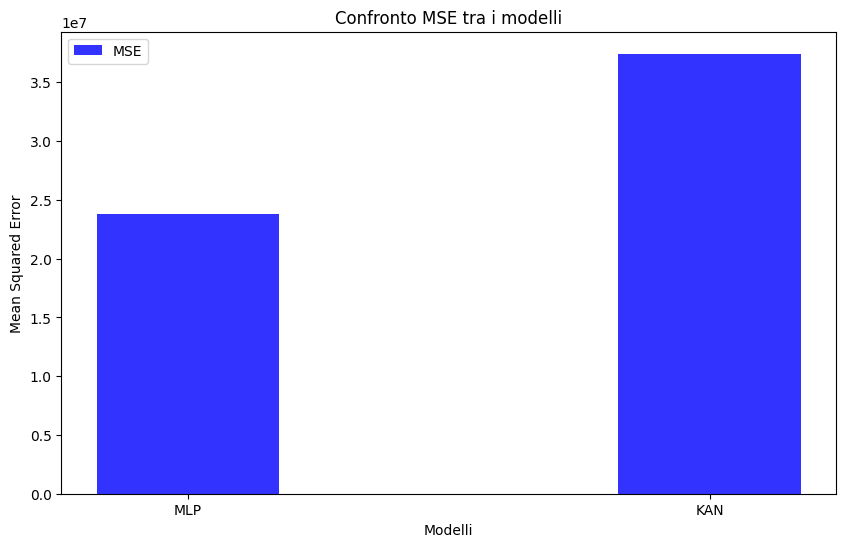

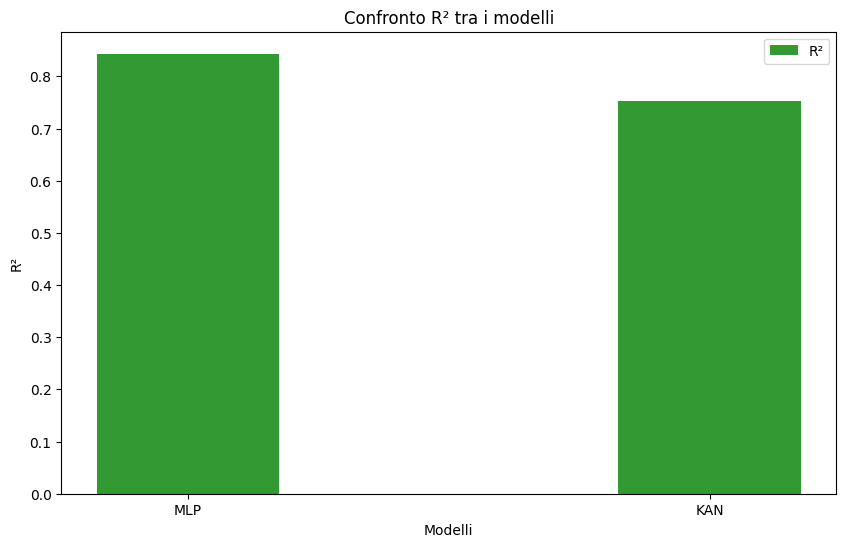

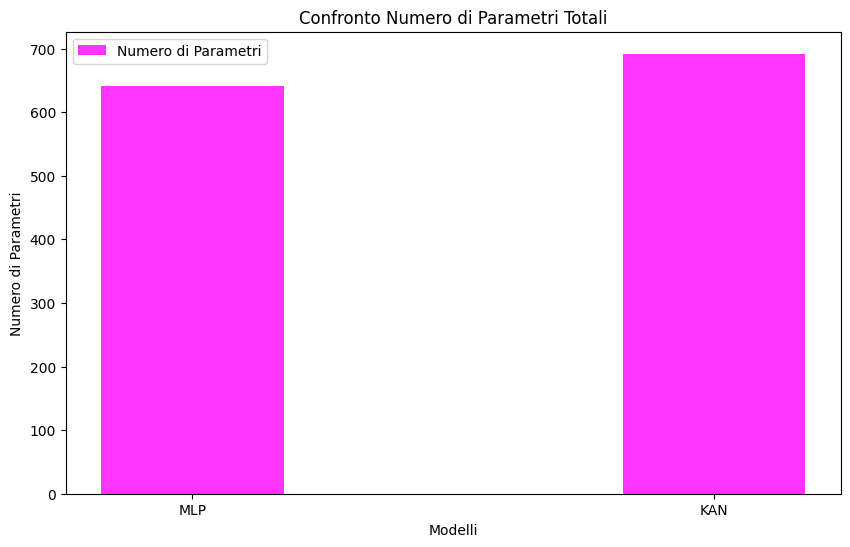

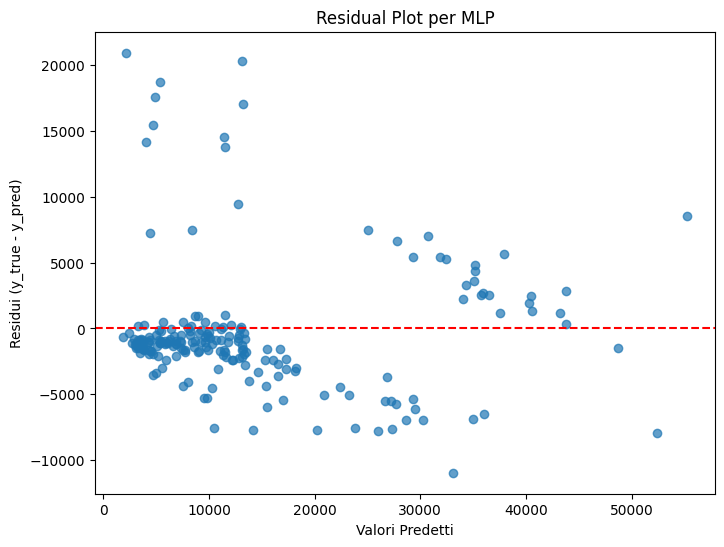

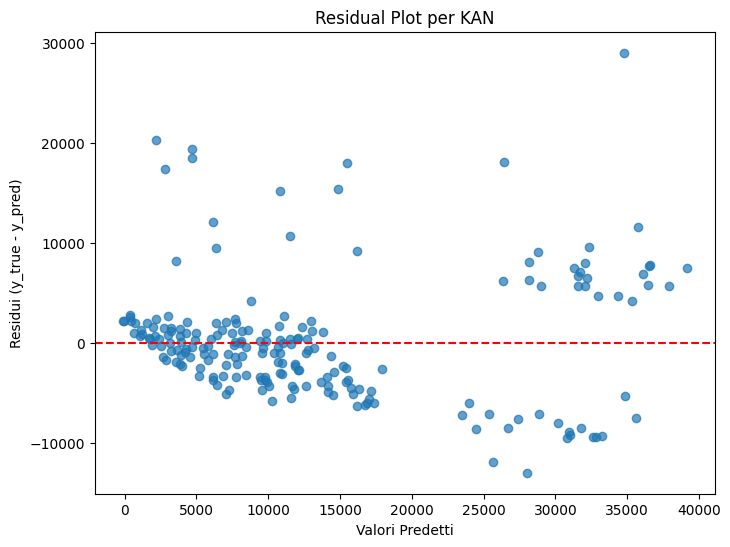

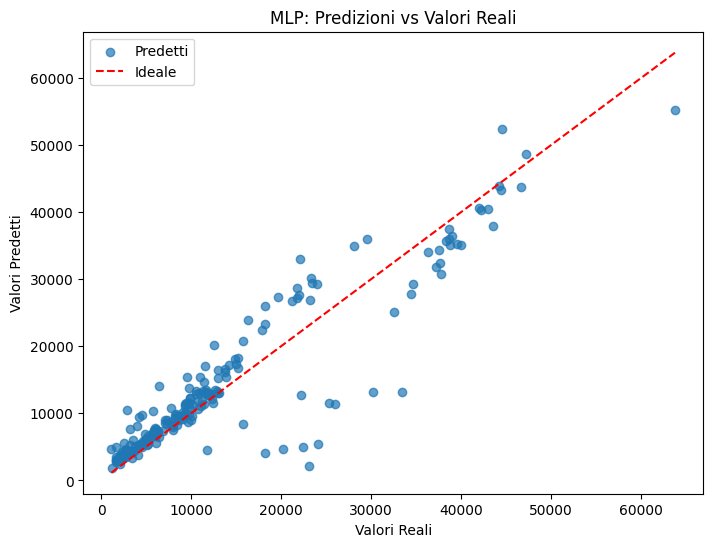

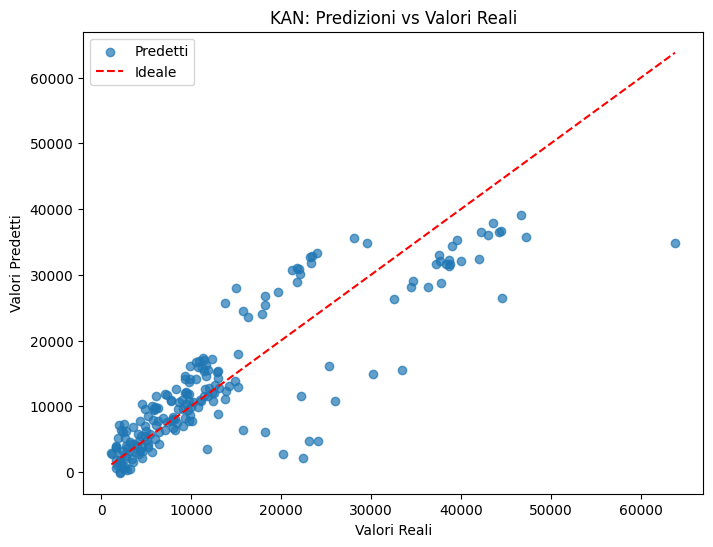

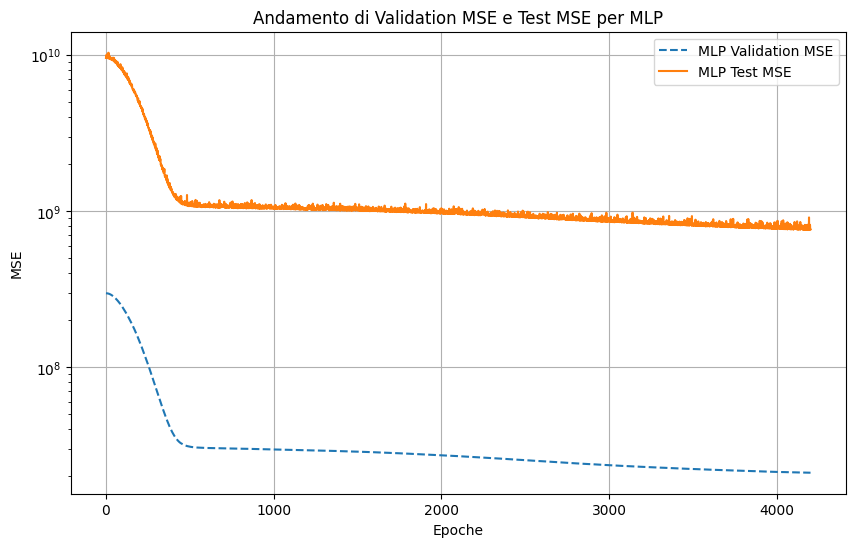

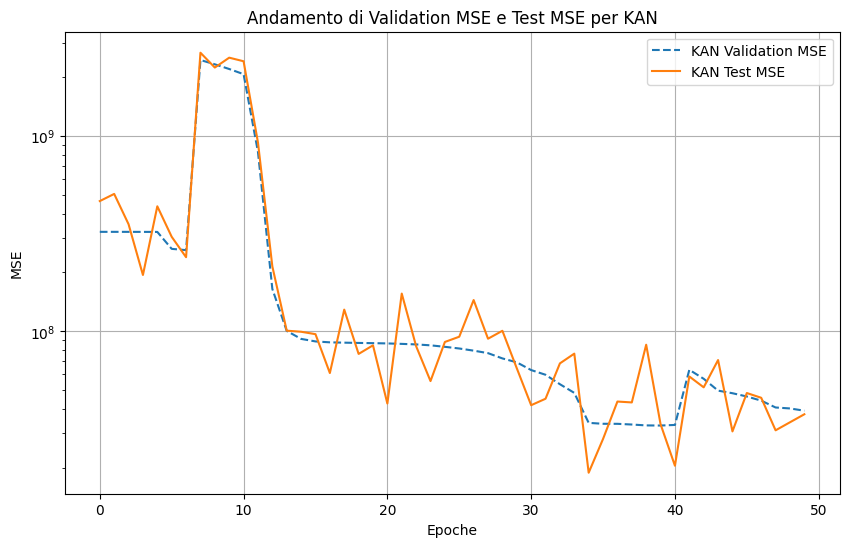

In [ ]:
# Conversione di X_test in tensore PyTorch e trasferimento sul dispositivo
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Creiamo un dizionario contenente i modelli
models = {'MLP': mlp_model,
          'KAN': kan_model}

# Liste per salvare le metriche
mse_values = []
r2_values = []
params_count = []

# Valutazione e stampa delle metriche per ciascun modello
for name, model in models.items():
    # Imposta il modello in modalità di valutazione
    model.eval()

    # Disabilita il calcolo dei gradienti
    with torch.no_grad():
        # Calcoliamo le predizioni passando i dati di test attraverso il modello
        predictions = model(X_test_tensor.to(device))  # X_test_tensor deve essere un tensore PyTorch
        predictions = predictions.cpu().numpy()  # Sposta le predizioni su CPU e convertilo in numpy array

    # Calcolo delle metriche
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Calcolo del numero di parametri
    params = sum(p.numel() for p in model.parameters())

    # Aggiungi i risultati alle liste
    mse_values.append(mse)
    r2_values.append(r2)
    params_count.append(params)

    # Stampa delle metriche
    print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}, Numero Parametri: {params}")

# --- Grafico a barre per il MSE ---
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(models))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, mse_values, bar_width, alpha=opacity, color='blue', label='MSE')
plt.xlabel('Modelli')
plt.ylabel('Mean Squared Error')
plt.title('Confronto MSE tra i modelli')
plt.xticks(index, list(models.keys()))
plt.legend()
plt.show()

# --- Grafico a barre per il coefficiente di determinazione (R²) ---
fig, ax = plt.subplots(figsize=(10,6))
rects2 = plt.bar(index, r2_values, bar_width, alpha=opacity, color='green', label='R²')
plt.xlabel('Modelli')
plt.ylabel('R²')
plt.title('Confronto R² tra i modelli')
plt.xticks(index, list(models.keys()))
plt.legend()
plt.show()

# --- Grafico a barre per il Numero di Parametri Totali ---
fig, ax = plt.subplots(figsize=(10,6))
rects3 = plt.bar(index, params_count, bar_width, alpha=opacity, color='magenta', label='Numero di Parametri')
plt.xlabel('Modelli')
plt.ylabel('Numero di Parametri')
plt.title('Confronto Numero di Parametri Totali')
plt.xticks(index, list(models.keys()))
plt.legend()
plt.show()

# Conversione di y_test in tensore PyTorch e trasferimento sul dispositivo
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# --- Residual Plot per ciascun modello ---
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.to(device))

    # Calcolo dei residui (y_true - y_pred)
    residuals = y_test_tensor.cpu() - predictions.cpu().flatten()

    # Creazione del grafico dei residui
    plt.figure(figsize=(8,6))
    plt.scatter(predictions.cpu(), residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot per {name}")
    plt.xlabel("Valori Predetti")
    plt.ylabel("Residui (y_true - y_pred)")
    plt.show()

# --- Scatter Plot per ogni modello ---
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.to(device))

    plt.figure(figsize=(8,6))
    plt.scatter(y_test_tensor.cpu(), predictions.cpu(), alpha=0.7, label="Predetti")
    plt.plot([y_test_tensor.cpu().min(), y_test_tensor.cpu().max()],
             [y_test_tensor.cpu().min(), y_test_tensor.cpu().max()],
             color='red', linestyle='--', label="Ideale")
    plt.title(f"{name}: Predizioni vs Valori Reali")
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.legend()
    plt.show()

# --- Grafico andamento MSE per MLP e KAN ---
for name in models.keys():
    plt.figure(figsize=(10, 6))
    plt.plot(mse_history[name]['val'], label=f"{name} Validation MSE", linestyle='dashed')
    plt.plot(mse_history[name]['test'], label=f"{name} Test MSE")
    plt.yscale('log')
    plt.xlabel("Epoche")
    plt.ylabel("MSE")
    plt.title(f"Andamento di Validation MSE e Test MSE per {name}")
    plt.legend()
    plt.grid()
    plt.show()

## 5. Analisi e Confronto delle Performance dei Modelli

Dopo aver addestrato i tre modelli (MLP, KAN e MLP with Spline), li abbiamo valutati utilizzando il test set. Le metriche di valutazione principali utilizzate sono:

- **Mean Squared Error (MSE):** misura l'errore medio quadratico tra i valori predetti e quelli reali. Un valore più basso indica una migliore capacità del modello di approssimare la relazione tra input e output.
- **Coefficiente di determinazione (R²):** indica quanto bene il modello spiega la varianza dei dati reali. Un valore vicino a 1 indica un'ottima capacità predittiva.
- **Numero di parametri:** fornisce un'idea della complessità del modello. Modelli con un numero elevato di parametri possono essere più soggetti a overfitting.

### Risultati ottenuti

Dai calcoli eseguiti, i risultati per ciascun modello sono:

In [ ]:
# Creiamo un DataFrame con i risultati
results_df = pd.DataFrame({
    'Modello': list(models.keys()),
    'MSE ↓': mse_values,
    'R² ↑': r2_values,
    'Numero Parametri ↓': params_count
})

# Ordinare la tabella per MSE (crescente) e Numero di Parametri (crescente)
results_df = results_df.sort_values(by=['MSE ↓', 'Numero Parametri ↓'], ascending=[True, True])

# Mostriamo la tabella
display(results_df)

,Modello,MSE ↓,R² ↑,Numero Parametri ↓
0,MLP,2.375570e+07,0.843351,641
1,KAN,3.742978e+07,0.753182,692


- **MSE:** Il modello con il valore più basso ha le migliori performance in termini di errore medio.
- **R²:** Un valore più alto suggerisce una maggiore capacità di spiegare la varianza del dataset.
- **Numero di parametri:** Modelli più complessi potrebbero essere più accurati ma anche più difficili da addestrare e più suscettibili a overfitting.

### Interpretazione dei grafici

#### **Grafico a barre del MSE**
Mostra chiaramente il modello con l'errore più basso. Se uno dei modelli ha un valore MSE significativamente più basso rispetto agli altri, è il più preciso nelle predizioni.

#### **Grafico a barre del coefficiente di determinazione (R²)**
Un valore vicino a 1 indica che il modello riesce a spiegare meglio la varianza dei dati reali. Se un modello ha un R² negativo o vicino a zero, significa che non è efficace nella previsione.

#### **Grafico a barre del numero di parametri**
Un modello con un numero di parametri molto elevato potrebbe essere più soggetto a overfitting, quindi è importante trovare un equilibrio tra accuratezza e complessità del modello.

### Residual Plot
Il residual plot mostra la differenza tra i valori reali e quelli predetti. Idealmente, i residui dovrebbero essere distribuiti casualmente attorno a zero. Se si notano pattern evidenti nei residui, il modello potrebbe soffrire di problemi di underfitting o overfitting.

### Scatter Plot (Valori Reali vs Predetti)
Confronta visivamente le predizioni del modello con i valori reali. Una distribuzione ideale dei punti lungo la diagonale indica che le predizioni sono vicine ai valori reali.

### Conclusione
Dall'analisi, possiamo determinare quale modello è il migliore in termini di accuratezza, generalizzazione e complessità. Se un modello ha un basso MSE e un alto R² con un numero ragionevole di parametri, è probabilmente la scelta migliore. Tuttavia, se il modello più accurato ha un numero eccessivo di parametri, potrebbe essere necessario un compromesso tra prestazioni e complessità per evitare overfitting.

